In [15]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

## Load Bounding Boxes


In [21]:
df_x = pd.DataFrame({
    "x": [0, 1, 2],
    "page": [0, 0, 1]
})
df_y = pd.DataFrame({
    "y": [0, np.nan, np.nan],
    "page": [0, 0, 1]
})

df_t = pd.merge(df_x, df_y, on="page", how="left")
df_t = df_t.dropna(subset=["y"])
df_t

,x,page,y
0,0,0,0.0
2,1,0,0.0


In [12]:
file_name = "75YearsofEngineering"
df_bbs: pd.DataFrame = pd.read_pickle(f"results/{file_name}_bbs.pkl")
df_figures = df_bbs[df_bbs["type_str"] == "figure"]
df_others = df_bbs[df_bbs["type_str"] != "figure"]
df = pd.merge(df_figures, df_others, on="page", how="left")
df["xyxy_x"] = df["xyxy_x"].transform(lambda x: x[0])
df["xyxy_y"] = df["xyxy_y"].dropna().transform(lambda x: x[0])
df

,id_x,page,xyxy_x,image_array_x,type_x,type_str_x,type_conf_x,id_y,xyxy_y,image_array_y,type_y,type_str_y,type_conf_y
0,75YearsofEngineering_0_0,0,"[24.594837188720703, 190.00843811035156, 547.6...","[[[180, 133, 111], [180, 133, 111], [182, 135,...",3,figure,0.828285,75YearsofEngineering_0_1,"[245.9947509765625, 20.625307083129883, 324.87...","[[[178, 129, 111], [177, 127, 109], [178, 128,...",2.0,abandon,0.756994
1,75YearsofEngineering_0_0,0,"[24.594837188720703, 190.00843811035156, 547.6...","[[[180, 133, 111], [180, 133, 111], [182, 135,...",3,figure,0.828285,75YearsofEngineering_0_2,"[77.5875244140625, 125.02650451660156, 501.711...","[[[180, 130, 112], [181, 130, 113], [179, 129,...",0.0,title,0.474311
2,75YearsofEngineering_0_0,0,"[24.594837188720703, 190.00843811035156, 547.6...","[[[180, 133, 111], [180, 133, 111], [182, 135,...",3,figure,0.828285,75YearsofEngineering_0_3,"[77.5875244140625, 125.02650451660156, 501.711...","[[[180, 130, 112], [181, 130, 113], [179, 129,...",1.0,plain text,0.294476
3,75YearsofEngineering_1_0,1,"[188.08712768554688, 209.71755981445312, 412.9...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.907374,NaN,NaN,NaN,NaN,NaN,NaN
4,75YearsofEngineering_2_1,2,"[248.7919921875, 519.5856323242188, 343.337707...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.718801,75YearsofEngineering_2_0,"[164.08480834960938, 432.4455871582031, 428.67...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",0.0,title,0.771073
...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,75YearsofEngineering_280_3,280,"[218.23641967773438, 532.0631103515625, 369.84...","[[[255, 255, 255], [255, 255, 255], [244, 244,...",3,figure,0.957454,75YearsofEngineering_280_6,"[284.16351318359375, 769.294677734375, 303.536...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",2.0,abandon,0.892983
522,75YearsofEngineering_299_3,299,"[231.28924560546875, 304.2211608886719, 364.73...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.251712,75YearsofEngineering_299_0,"[212.32261657714844, 195.39752197265625, 334.7...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",2.0,abandon,0.769107
523,75YearsofEngineering_299_3,299,"[231.28924560546875, 304.2211608886719, 364.73...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.251712,75YearsofEngineering_299_1,"[273.3109436035156, 117.44023132324219, 337.68...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",2.0,abandon,0.484484
524,75YearsofEngineering_299_3,299,"[231.28924560546875, 304.2211608886719, 364.73...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.251712,75YearsofEngineering_299_2,"[273.3109436035156, 117.44023132324219, 337.68...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",1.0,plain text,0.343066


## Link Figure with Figure Caption


In [5]:
def box_dist(box1: list[float], box2: list[float]) -> float:
    """
    Calculate the cartesian distance between two bounding boxes by their closest points.

    :param box1: [x1, y1, x2, y2]
    :param box2: [x1, y1, x2, y2]
    :return: distance between the two boxes
    """
    ax1, ay1, bx1, by1 = box1
    ax2, ay2, bx2, by2 = box2
    left = bx2 < ax1
    right = bx1 < ax2
    bottom = by2 < ay1
    top = by1 < ay2
    if top and left:
        return ax1 - bx2 + ay2 - by1
    elif left and bottom:
        return ax1 - bx2 + ay1 - by2
    elif bottom and right:
        return ax2 - bx1 + ay1 - by2
    elif right and top:
        return ax2 - bx1 + ay2 - by1
    elif left:
        return ax1 - bx2
    elif right:
        return ax2 - bx1
    elif bottom:
        return ay1 - by2
    elif top:
        return ay2 - by1
    else:  # Intersect
        return 0.0

In [ ]:
df_t = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                                'Parrot', 'Parrot'],
                     'Max Speed': [380., 370., 24., 26.]})

for i, x in df_t.groupby("Animal"):
    print(x)

   Animal  Max Speed
0  Falcon      380.0
1  Falcon      370.0
   Animal  Max Speed
2  Parrot       24.0
3  Parrot       26.0


In [ ]:
def link_figure_with_caption(
    df: pd.DataFrame,
    threshold: float = 15,
    multiple_captions: bool = False,
) -> pd.DataFrame:
    """
    Link figures with their captions based on the distance between the bounding boxes.

    :param df: DataFrame with bounding boxes of figures and captions
    :param threshold: Maxmum distance after the closest other bounding box to link
    :param multiple_captions: Allow multiple captions per figure
    :return: DataFrame with the linked figures and captions
    """
    result = {}
    for id_x, df_group in tqdm(df.groupby("id_x")):
        if df_group["type_str_y"].isnull().all():
            continue
        df_group["dist"] = df_group.apply(
            lambda x: box_dist(x["xyxy_x"], x["xyxy_y"]),
            axis=1,
        )
        df_group = df_group[df_group["dist"] <=
                            df_group["dist"].min() + threshold]
        df_group = df_group[df_group["type_str_y"] == "figure_caption"]

        if not multiple_captions:
            df_group = df_group[df_group["dist"] == df_group["dist"].min()]

        result[id_x] = df_group.reset_index()[["index", "id_y"]].values

    return pd.DataFrame(
        [
            (figure_id, figure_caption_id)
            for figure_id, figure_caption_ids in result.items()
            for _, figure_caption_id in figure_caption_ids
        ],
        index=[
            index
            for _, figure_caption_ids in result.items()
            for index, _ in figure_caption_ids
        ],
        columns=["figure_id", "figure_caption_id"],
    ).sort_index()

In [8]:
links = link_figure_with_caption(df)

  0%|          | 0/127 [00:00<?, ?it/s]

100%|██████████| 127/127 [00:00<00:00, 958.12it/s] 


## Save Figure Caption Links


In [9]:
links.to_pickle(f"results/{file_name}_caps.pkl")

## Show Figure and Figure Caption Images


In [ ]:
df_linked = pd.merge(df_figures, links, left_on="id", right_on="figure_id")
df_linked = pd.merge(df_linked, df_others,
                     left_on="figure_caption_id", right_on="id")
df_linked

,id_x,page_x,xyxy_x,image_array_x,type_x,type_str_x,type_conf_x,figure_id,figure_caption_id,id_y,page_y,xyxy_y,image_array_y,type_y,type_str_y,type_conf_y
0,75YearsofEngineering_15_0,15,"[[80.93217468261719, 453.8595275878906, 441.23...","[[[252, 255, 253], [252, 255, 253], [252, 255,...",3,figure,0.979209,75YearsofEngineering_15_0,75YearsofEngineering_15_3,75YearsofEngineering_15_3,15,"[[99.4372787475586, 703.86474609375, 426.27813...","[[[252, 255, 253], [252, 255, 253], [252, 255,...",4,figure_caption,0.870373
1,75YearsofEngineering_15_1,15,"[[138.3887939453125, 102.94281768798828, 384.5...","[[[252, 255, 253], [252, 255, 253], [252, 255,...",3,figure,0.975749,75YearsofEngineering_15_1,75YearsofEngineering_15_2,75YearsofEngineering_15_2,15,"[[60.285648345947266, 417.1078796386719, 462.0...","[[[252, 255, 253], [252, 255, 253], [252, 255,...",4,figure_caption,0.907399
2,75YearsofEngineering_16_0,16,"[[279.16217041015625, 503.1180114746094, 485.3...","[[[249, 254, 252], [197, 217, 222], [126, 133,...",3,figure,0.976609,75YearsofEngineering_16_0,75YearsofEngineering_16_6,75YearsofEngineering_16_6,16,"[[289.0022888183594, 688.7200317382812, 476.60...","[[[252, 255, 253], [252, 255, 253], [252, 255,...",4,figure_caption,0.821812
3,75YearsofEngineering_16_1,16,"[[281.60687255859375, 122.68223571777344, 486....","[[[251, 255, 253], [235, 244, 245], [229, 230,...",3,figure,0.972731,75YearsofEngineering_16_1,75YearsofEngineering_16_5,75YearsofEngineering_16_5,16,"[[289.9397277832031, 408.0585632324219, 476.94...","[[[248, 253, 251], [248, 253, 251], [248, 253,...",4,figure_caption,0.913553
4,75YearsofEngineering_16_2,16,"[[68.20008850097656, 122.10366821289062, 271.1...","[[[252, 255, 253], [243, 249, 248], [206, 210,...",3,figure,0.971609,75YearsofEngineering_16_2,75YearsofEngineering_16_9,75YearsofEngineering_16_9,16,"[[73.60688018798828, 352.37091064453125, 259.0...","[[[248, 251, 249], [245, 248, 246], [252, 255,...",4,figure_caption,0.582132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,75YearsofEngineering_265_3,265,"[[149.0196533203125, 202.859130859375, 465.927...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.962285,75YearsofEngineering_265_3,75YearsofEngineering_265_4,75YearsofEngineering_265_4,265,"[[165.98133850097656, 510.0244445800781, 446.5...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",4,figure_caption,0.929240
107,75YearsofEngineering_268_0,268,"[[115.48295593261719, 159.54473876953125, 467....","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.970766,75YearsofEngineering_268_0,75YearsofEngineering_268_4,75YearsofEngineering_268_4,268,"[[132.2495880126953, 426.39483642578125, 450.8...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",4,figure_caption,0.470370
108,75YearsofEngineering_273_0,273,"[[113.84516143798828, 136.59091186523438, 514....","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.927686,75YearsofEngineering_273_0,75YearsofEngineering_273_3,75YearsofEngineering_273_3,273,"[[284.4412536621094, 618.2660522460938, 478.71...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",4,figure_caption,0.644871
109,75YearsofEngineering_278_3,278,"[[106.57506561279297, 491.41754150390625, 492....","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.897681,75YearsofEngineering_278_3,75YearsofEngineering_278_5,75YearsofEngineering_278_5,278,"[[126.12054443359375, 720.283447265625, 447.64...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",4,figure_caption,0.337543


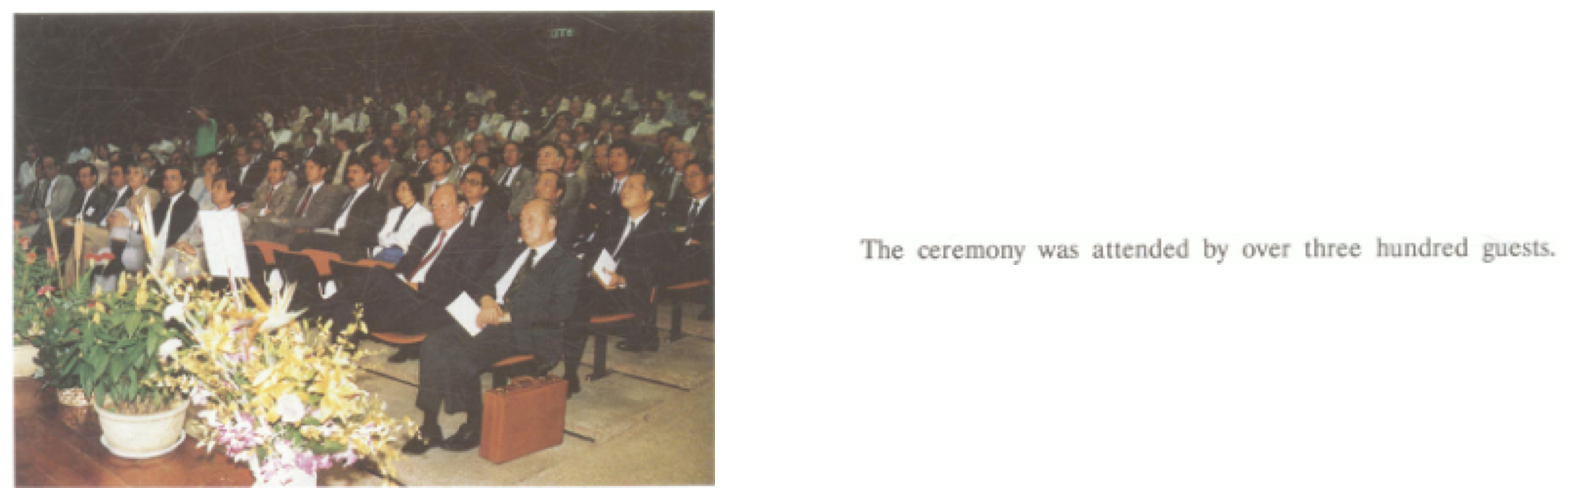

In [126]:
figure_image = df_linked["image_array_x"].values
figure_caption_image = df_linked["image_array_y"].values
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(cv2.cvtColor(figure_image[0], cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(cv2.cvtColor(figure_caption_image[0], cv2.COLOR_BGR2RGB))